## III. Feature selection, algorithm improvement

In this notebook, I shall run improve the best model from the preivous notebook (SVM Classificator) by undertaking the following steps:
    - Feature selection (Hybrid method: recursive feature addition)
    - Tune hyper paramters

Then I shall check and prove the improvement.

ROC visualization is provided at the end of the notebook

### 1 Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn import svm

from sklearn.metrics import roc_curve

from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
%matplotlib inline

### 2. Import datasets 

In [2]:
# Merge the two datasets
X_train=pd.read_csv('X_train.csv',sep= ',')
X_train.shape

(807, 22)

In [3]:
X_test=pd.read_csv('X_test.csv',sep= ',')
X_test.shape

(143, 22)

In [4]:
# Merge the two datasets
y_train=pd.read_csv('y_train.csv',sep= ',')
y_train.shape

(807, 1)

In [5]:
y_test=pd.read_csv('y_test.csv',sep= ',')
y_test.shape

(143, 1)

### 3. Model creation & data balancing 



#### 3.2 Smote for data imbalance

In [6]:
train_input = X_train
train_output = y_train


In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(train_input, train_output)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({'CreditStatus': 1})
New dataset shape Counter({0: 439, 1: 439})


In [8]:
train_input_new = X_train
train_ouput_new = y_train

Now both outcomes of the label are balanced

### 4. Feature selection (Feature addition)

In [9]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = RandomForestClassifier()
model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features RFC ROC AUC=%f' % (auc_score_all))

Test all features RFC ROC AUC=0.870869


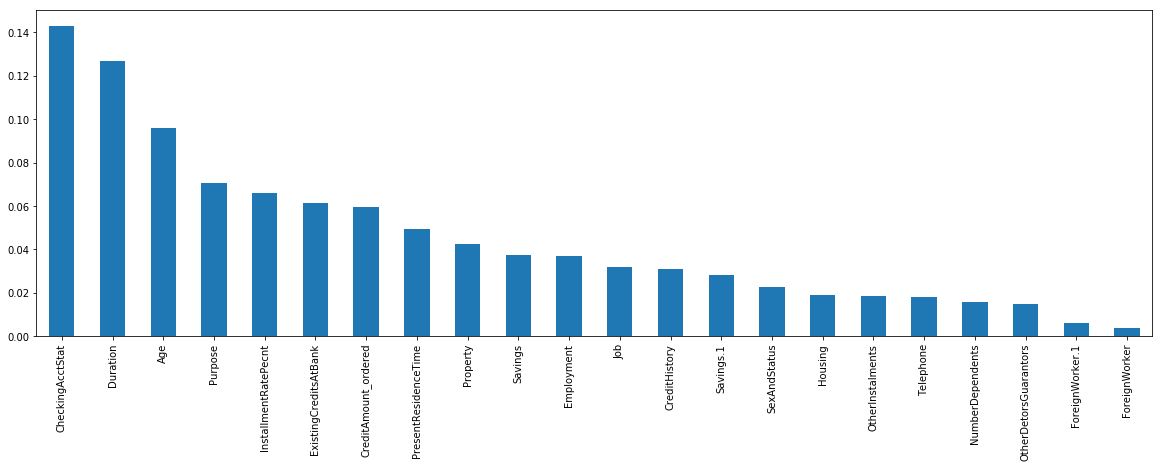

In [10]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [11]:
# view the list of ordered features
features = list(features.index)
features

['CheckingAcctStat',
 'Duration',
 'Age',
 'Purpose',
 'InstallmentRatePecnt',
 'ExistingCreditsAtBank',
 'CreditAmount_ordered',
 'PresentResidenceTime',
 'Property',
 'Savings',
 'Employment',
 'Job',
 'CreditHistory',
 'Savings.1',
 'SexAndStatus',
 'Housing',
 'OtherInstalments',
 'Telephone',
 'NumberDependents',
 'OtherDetorsGuarantors',
 'ForeignWorker.1',
 'ForeignWorker']

In [12]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = RandomForestClassifier()

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_test, y_pred_test)
print('Test one feature xgb ROC AUC=%f' % (auc_score_first))

Test one feature xgb ROC AUC=0.721236


In [13]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = RandomForestClassifier()

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  Duration  which is feature  1  out of  22
New Test ROC AUC=0.8905548755609956
All features Test ROC AUC=0.7212362301101592
Increase in ROC AUC=0.1693186454508363
keep:  Duration

testing feature:  Age  which is feature  2  out of  22
New Test ROC AUC=0.8311913504691961
All features Test ROC AUC=0.8905548755609956
Increase in ROC AUC=-0.05936352509179943
remove:  Age

testing feature:  Purpose  which is feature  3  out of  22
New Test ROC AUC=0.7895756833945328
All features Test ROC AUC=0.8905548755609956
Increase in ROC AUC=-0.10097919216646278
remove:  Purpose

testing feature:  InstallmentRatePecnt  which is feature  4  out of  22
New Test ROC AUC=0.8853529171766625
All features Test ROC AUC=0.8905548755609956
Increase in ROC AUC=-0.005201958384333016
remove:  InstallmentRatePecnt

testing feature:  ExistingCreditsAtBank  which is feature  5  out of  22
New Test ROC AUC=0.8177274581803345
All features Test ROC AUC=0.8905548755609956

Amazing, we go down from 22 to 4 featues, and yet we increase our ROC!

In [14]:
# capture the 4 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = RandomForestClassifier()

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.899021


### 5. Tune mode hyperparamters


In [15]:

from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']


# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
from sklearn.ensemble import RandomForestClassifier
#making the instance
rfc=RandomForestClassifier()
# Random search of parameters
rfc_model = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_model.fit(X_train[features_to_keep], y_train)
# print results
print(rfc_model.best_params_)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


{'n_estimators': 600, 'max_features': 'auto', 'max_depth': 180}


Now we test best parameters below

In [23]:
seed_val = 1000

np.random.seed(seed_val)

rfc2 = RandomForestClassifier(n_estimators=600, max_depth=180, max_features='auto')
rfc2.fit(X_train[features_to_keep],y_train)
rfc2_predict = rfc2.predict_proba(X_test[features_to_keep])[:, 1]

auc_score_final2 = roc_auc_score(y_test, rfc2_predict)
print('Test selected features ROC AUC=%f' % (auc_score_final2))




Test selected features ROC AUC=0.914219


**Check for improvement**

In [24]:
print ('Model ROC AUC improvement is',(auc_score_final2-auc_score_final))


Model ROC AUC improvement is 0.015197878416972732


If we compare original ROC AUC with the latest one, we find:

In [25]:
print('Test all features RFC ROC AUC=%f' % (auc_score_all))
print('Test selected features ROC AUC=%f' % (auc_score_final2))
print ('Model ROC AUC change is',(auc_score_final2-auc_score_all))

Test all features RFC ROC AUC=0.870869
Test selected features ROC AUC=0.914219
Model ROC AUC change is 0.04334965320277451


We have improved our model accuracy by 0.04 and reduced the featuer space by 22 to 4!

**7.Save the model**

In [26]:
from sklearn.externals import joblib
from joblib import dump, load
dump(rfc2,'model1.joblib')  

['model1.joblib']

#### 8. Evidence that the model will generalize well

In [27]:
df = pd.concat([X_train.append(X_test), y_train.append(y_test)], axis = 1)

In [28]:

import sklearn.metrics as sklm

labels = np.array(df['CreditStatus'])
probabilities = rfc2.predict_proba(X_test[features_to_keep])

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        46                11
Actual negative        11                75

Accuracy  0.85
 
           Positive      Negative
Num case       57            86
Precision    0.81          0.87
Recall       0.81          0.87
F1           0.81          0.87


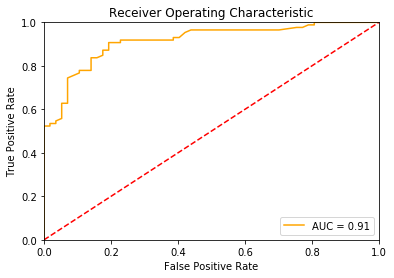

In [29]:

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)